In [1]:
from facenet_pytorch import MTCNN, extract_face
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.3'


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cpu


In [3]:
detector = MTCNN(device=device)

In [4]:
# https://stackoverflow.com/questions/14063070/overlay-a-smaller-image-on-a-larger-image-python-opencv
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

In [90]:
def apply_occlusion_on_face(img_path, occl_path, occl_landmarks, detector):
    img = np.asarray(Image.open(img_path))
    msk = np.asarray(Image.open(occl_path))

    assert msk.shape[2] == 4, "Occlusion image should be in RGBA format"

    # Detect facial landmarks
    boxes, probs, points = detector.detect(img, landmarks=True)

    if points is None:
        print(f"No face detected in image {img_path}")
        return

    # Apply transform to occlusion to match landmarks
    pts = np.array(occl_landmarks, dtype=np.float32)
    tgt = points[0][2:].astype(np.float32)
    diff = tgt[0] - pts[0]

    transform = cv2.getAffineTransform(pts, tgt - diff)
    msk_transformed = cv2.warpAffine(msk, transform, msk.shape[:2])

    # Blend mask on original image
    alpha_mask = msk_transformed[:,:,3] / 255.0
    mask_rgb   = msk_transformed[:,:,:3]

    overlay_image_alpha(img, mask_rgb, int(tgt[0][0] - pts[0][0]), int(tgt[0][1] - pts[0][1]), alpha_mask)
    
    return img


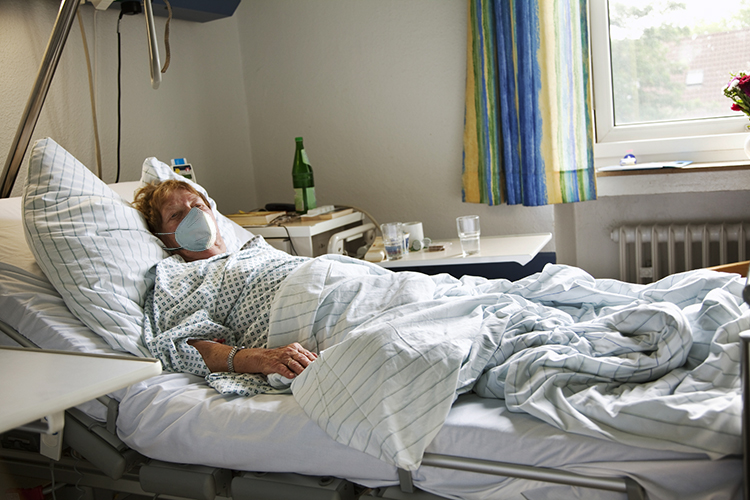

In [91]:
img = apply_occlusion_on_face('patient4.jpg', 'mask-1.png', [[98, 49], [75, 90], [110,90]], detector)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
display.display(Image.fromarray(img))

Detected facial landmarks:


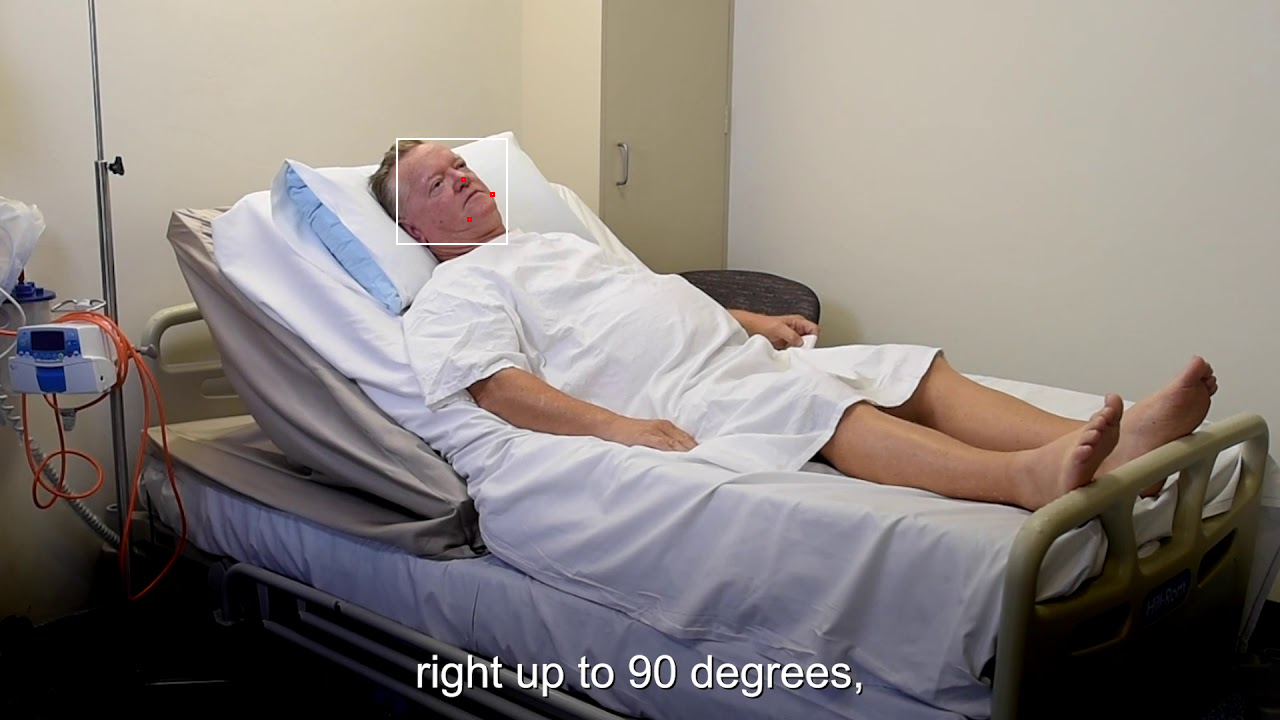

[[ 98.  49.]
 [ 75.  90.]
 [110.  90.]]
[[ 98.        49.      ]
 [103.96686   89.285995]
 [127.76303   64.04271 ]]
(150, 150)
Original facial occlusion


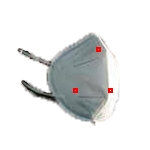

Transformed facial occlusion


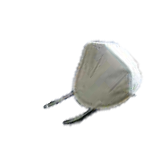

(150, 150, 4)
[98 49]
Result


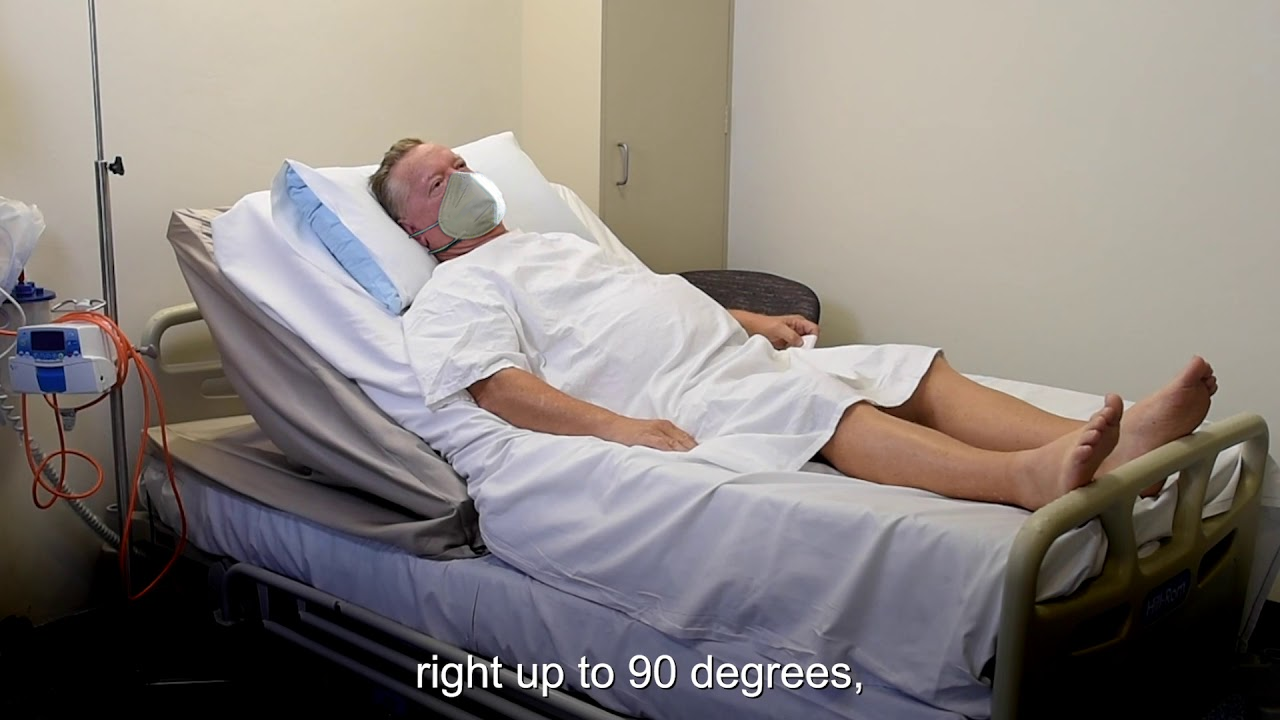

In [53]:
img = Image.open('patient3.jpg')
msk = Image.open('mask-1.png')
_img = np.array(img)
_msk = np.array(msk)

# STEP 1: FACE AND FACIAL LANDMARKS DETECTION
boxes, probs, points = detector.detect(_img, landmarks=True)

img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
    draw.rectangle(box.tolist(), width=2)
    for p in point[2:]:
        draw.rectangle((p - 2).tolist() + (p + 2).tolist(), width=2, outline=(255, 0, 0))

print("Detected facial landmarks:")
display.display(img_draw)

# STEP 2: COMPUTING TRANSFORMATION ON FACIAL OCCLUSION IMAGE TO MATCH THE DETECTED FACIAL LANDMARKS
msk_draw = msk.copy()
draw = ImageDraw.Draw(msk_draw)
pts = np.array([[98, 49], [75, 90], [110,90]], dtype=np.float32)

for p in pts:
    draw.rectangle((p - 2).tolist() + (p + 2).tolist(), width=2, outline=(255, 0, 0))

mask = cv2.imread('mask-1.png', cv2.IMREAD_UNCHANGED)

tgt = point[2:].astype(np.float32)
diff = tgt[0] - pts[0]
transform = cv2.getAffineTransform(pts, tgt - diff)
print(pts)
print(tgt-diff)
mask2 = cv2.warpAffine(mask, transform, msk.size)

print("Original facial occlusion")
display.display(msk_draw)
print("Transformed facial occlusion")
display.display(Image.fromarray(mask2))
print(mask2.shape)

# STEP 3: APPLY FACIAL OCCLUSION ON ORIGINAL IMAGE
alpha_mask = mask2[:,:,3] / 255.0
mask_rgb = mask2[:,:,:3]
img_draw = _img.copy()
pos = pts[0].astype(int)# (transform.T @ pts[0]).astype(int)
print(pos)
overlay_image_alpha(img_draw, mask_rgb, int(tgt[0][0]) - pos[0], int(tgt[0][1]) - pos[1], alpha_mask)
print("Result")
display.display(Image.fromarray(img_draw))
